## 4. 패션 아이템을 구분하는 DNN

### 4.1 Fashion MNIST 데이터셋 알아보기

In [1]:
from torchvision import datasets, transforms, utils
from torch.utils import data

In [2]:
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# 이미지를 텐서로 바꿔주는 코드
transform = transforms.Compose([transforms.ToTensor()])

In [4]:
trainset = datasets.FashionMNIST(
root      = './ .data/',
train     = True,
download  = True,
transform = transform)

testset  = datasets.FashionMNIST(
root      = './ .data/',
train     = False,
download  = True,
transform = transform
)

95.7%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

111.0%

Extracting ./ .data/FashionMNIST\raw\train-labels-idx1-ubyte.gz to ./ .data/FashionMNIST\raw


100.0%

Extracting ./ .data/FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ./ .data/FashionMNIST\raw


159.1%c:\users\xowns\anaconda3\envs\tensorflow\lib\site-packages\torchvision\datasets\mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Extracting ./ .data/FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ./ .data/FashionMNIST\raw
Processing...
Done!


In [5]:
batch_size = 16

train_loader = data.DataLoader(
dataset = trainset,
batch_size = batch_size)

test_loader = data.DataLoader(
dataset = testset,
batch_size = batch_size)

In [6]:
dataiter       = iter(train_loader) # 반복문 안에서 이용할 수 있도록
images, labels = next(dataiter)

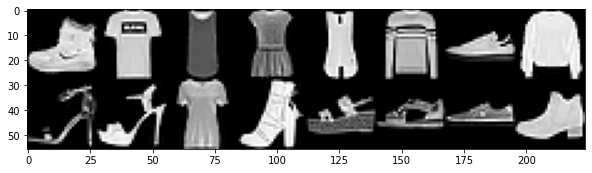

In [7]:
img = utils.make_grid(images, padding=0)
npimg = img.numpy()
plt.figure(figsize=(10, 7))
plt.imshow(np.transpose(npimg, (1,2,0)))
plt.show()

In [8]:
print(labels)

tensor([9, 0, 0, 3, 0, 2, 7, 2, 5, 5, 0, 9, 5, 5, 7, 9])


In [9]:
CLASSES = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

In [10]:
for label in labels:
    index = label.item()
    print(CLASSES[index])

Ankle boot
T-shirt/top
T-shirt/top
Dress
T-shirt/top
Pullover
Sneaker
Pullover
Sandal
Sandal
T-shirt/top
Ankle boot
Sandal
Sandal
Sneaker
Ankle boot


### 4.2 인공 신경망으로 패션 아이템 분류하기

#### 4.2.1 환경 설정하기

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, datasets

In [12]:
USE_CUDA = torch.cuda.is_available()
DEVICE   = torch.device("cuda" if USE_CUDA else "cpu")

In [13]:
EPOCHS = 30
BATCH_SIZE = 64

#### 4.2.3 이미지 분류를 위한 인공 신경망 구현

In [15]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
    def forward(self, x):
        x = x.view(-1, 784)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [16]:
model = Net().to(DEVICE)

In [17]:
optimizer = optim.SGD(model.parameters(), lr=0.01)

### 4.3 성능 측정하기

In [19]:
def train(model, train_loader, optimzier):
    model.train() # 모델을 학습 모드로 바꿔놓음
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(DEVICE), target.to(DEVICE)
        optimizer.zero_grad() # 반복 때마다 기울기를 새로 계산하므로 함수 호출
        output = model(data)
        
        loss = F.cross_entropy(output, target) # 클래스가 10개니 cross_entropy 사용
        loss.backward()
        optimizer.step() # 계산한 기울기를 앞서 정의한 알고리즘에 맞추어 가중치를 수정

def evaluate(model, test_loader):
    model.eval() # 모델을 평가 모드로 바꿈
    test_loss = 0
    correct = 0
    with torch.no_grad(): # 평가 과정에서는 기울기를 계산하지 않아도 된다
        for data, target in test_loader:
            data, target= data.to(DEVICE), target.to(DEVICE)
            output = model(data)
            
            # 모든 오차 더하기
            test_loss += F.cross_entropy(output, target, reduction='sum').item()
            
            # 가장 큰 값을 가진 클래스가 모델의 예측입니다.
            # 예측과 정답을 비교하여 일치할 경우 correct에 1을 더합니다.
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()
            
    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

# 학습 및 평가
for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer)
    test_loss, test_accuracy = evaluate(model, test_loader)
    
    print('[{}] Test Loss: {:.4f}, Accuracy: {:.2f}%'.format(epoch, test_loss, test_accuracy))

[1] Test Loss: 0.4969, Accuracy: 82.24%
[2] Test Loss: 0.4548, Accuracy: 83.91%
[3] Test Loss: 0.4290, Accuracy: 84.87%
[4] Test Loss: 0.4092, Accuracy: 85.55%
[5] Test Loss: 0.3948, Accuracy: 86.02%
[6] Test Loss: 0.3828, Accuracy: 86.37%
[7] Test Loss: 0.3739, Accuracy: 86.59%
[8] Test Loss: 0.3663, Accuracy: 86.74%
[9] Test Loss: 0.3610, Accuracy: 86.88%
[10] Test Loss: 0.3574, Accuracy: 87.04%
[11] Test Loss: 0.3536, Accuracy: 87.28%
[12] Test Loss: 0.3472, Accuracy: 87.66%
[13] Test Loss: 0.3447, Accuracy: 87.79%
[14] Test Loss: 0.3432, Accuracy: 87.91%
[15] Test Loss: 0.3400, Accuracy: 88.08%
[16] Test Loss: 0.3381, Accuracy: 88.15%
[17] Test Loss: 0.3368, Accuracy: 88.22%
[18] Test Loss: 0.3360, Accuracy: 88.40%
[19] Test Loss: 0.3366, Accuracy: 88.35%
[20] Test Loss: 0.3366, Accuracy: 88.51%
[21] Test Loss: 0.3358, Accuracy: 88.40%
[22] Test Loss: 0.3352, Accuracy: 88.47%
[23] Test Loss: 0.3354, Accuracy: 88.37%
[24] Test Loss: 0.3396, Accuracy: 88.27%
[25] Test Loss: 0.3388, A

### 4.4 과적합과 드롭아웃

#### 4.4.1 데이터 늘리기

In [20]:
train_loader = torch.utils.data.DataLoader(
datasets.MNIST('./ .data', train=True, download=True,
              transform = transforms.Compose([
                  transforms.RandomHorizontalFlip(),
                  transforms.ToTensor(),
                  transforms.Normalize((0.1307,), (0.3081,))
              ])),
batch_size = BATCH_SIZE, shuffle=True)

test_loader = torch.utils.data.DataLoader(
datasets.MNIST('./ .data', train=False,
              transform = transforms.Compose([
                  transforms.ToTensor(),
                  transforms.Normalize((0.1307,),(0.3081,))
              ])),
batch_size = BATCH_SIZE, shuffle=True)

100.1%

Extracting ./ .data\MNIST\raw\train-images-idx3-ubyte.gz to ./ .data\MNIST\raw


113.5%

Extracting ./ .data\MNIST\raw\train-labels-idx1-ubyte.gz to ./ .data\MNIST\raw


100.4%

Extracting ./ .data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./ .data\MNIST\raw


180.4%

Extracting ./ .data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./ .data\MNIST\raw
Processing...
Done!


#### 4.4.2 드롭아웃

In [21]:
class Net(nn.Module):
    def __init__(self, dropout_p=0.2):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
        # 드롭아웃 확률
        self.dropout_p = dropout_p
    def forward(self, x):
        x = x.view(-1, 784)
        x = F.relu(self.fc1(x))
        # 드롭아웃 추가
        x = F.dropout(x, training=self.training, p=self.dropout_p)
        x = F.relu(self.fc2(x))
        # 드롭아웃 추가
        x = F.dropout(x, training=self.training, p=self.dropout_p)
        x = self.fc3(x)
        return x

In [24]:
model = Net(dropout_p=0.2).to(DEVICE)
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [25]:
def train(model, train_loader, optimzier):
    model.train() # 모델을 학습 모드로 바꿔놓음
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(DEVICE), target.to(DEVICE)
        optimizer.zero_grad() # 반복 때마다 기울기를 새로 계산하므로 함수 호출
        output = model(data)
        
        loss = F.cross_entropy(output, target) # 클래스가 10개니 cross_entropy 사용
        loss.backward()
        optimizer.step() # 계산한 기울기를 앞서 정의한 알고리즘에 맞추어 가중치를 수정

def evaluate(model, test_loader):
    model.eval() # 모델을 평가 모드로 바꿈
    test_loss = 0
    correct = 0
    with torch.no_grad(): # 평가 과정에서는 기울기를 계산하지 않아도 된다
        for data, target in test_loader:
            data, target= data.to(DEVICE), target.to(DEVICE)
            output = model(data)
            
            # 모든 오차 더하기
            test_loss += F.cross_entropy(output, target, reduction='sum').item()
            
            # 가장 큰 값을 가진 클래스가 모델의 예측입니다.
            # 예측과 정답을 비교하여 일치할 경우 correct에 1을 더합니다.
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()
            
    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy


In [26]:
for epoch in range(1, EPOCHS+1):
    train(model, train_loader, optimizer)
    test_loss, test_accuracy = evaluate(model, test_loader)
    
    print('[{}] Test Loss: {:.4f}, Accuracy: {:.2f}%'.format(epoch, test_loss, test_accuracy))

[1] Test Loss: 0.5433, Accuracy: 82.70%
[2] Test Loss: 0.4162, Accuracy: 87.09%
[3] Test Loss: 0.3372, Accuracy: 89.55%
[4] Test Loss: 0.2859, Accuracy: 91.41%
[5] Test Loss: 0.2508, Accuracy: 92.22%
[6] Test Loss: 0.2216, Accuracy: 93.08%
[7] Test Loss: 0.2053, Accuracy: 93.61%
[8] Test Loss: 0.1854, Accuracy: 94.41%
[9] Test Loss: 0.1744, Accuracy: 94.58%
[10] Test Loss: 0.1635, Accuracy: 95.02%
[11] Test Loss: 0.1552, Accuracy: 95.25%
[12] Test Loss: 0.1485, Accuracy: 95.46%
[13] Test Loss: 0.1439, Accuracy: 95.58%
[14] Test Loss: 0.1366, Accuracy: 95.82%
[15] Test Loss: 0.1328, Accuracy: 95.82%
[16] Test Loss: 0.1306, Accuracy: 95.79%
[17] Test Loss: 0.1242, Accuracy: 96.13%
[18] Test Loss: 0.1199, Accuracy: 96.28%
[19] Test Loss: 0.1183, Accuracy: 96.19%
[20] Test Loss: 0.1169, Accuracy: 96.29%
[21] Test Loss: 0.1130, Accuracy: 96.42%
[22] Test Loss: 0.1137, Accuracy: 96.36%
[23] Test Loss: 0.1084, Accuracy: 96.58%
[24] Test Loss: 0.1063, Accuracy: 96.74%
[25] Test Loss: 0.1049, A